In [1]:
# importing the packages
import pandas as pd


In [2]:
# Loading the data into the dataframes
dt_tag = pd.read_csv('data/tag.csv')
dt_rating = pd.read_csv('data/rating.csv')
dt_movie = pd.read_csv('data/movie.csv')
dt_link = pd.read_csv('data/link.csv')  
dt_genome_scores = pd.read_csv('data/genome_scores.csv')
dt_genome_tags = pd.read_csv('data/genome_tags.csv')  


# sampling 10% of the data in dt_tag to minimize the memory usage and to speed up the process
dt_tag = dt_tag.sample(frac=0.1, random_state=1)
dt_tag = dt_tag.rename(columns={'timestamp': 'tag_timestamp'})


In [14]:
# Merging the dataframes
dt = pd.merge(dt_tag, dt_rating, on=['userId', 'movieId'], how='inner')
dt = pd.merge(dt, dt_movie, on='movieId', how='inner')
dt = pd.merge(dt, dt_link, on='movieId', how='inner')
dt = pd.merge(dt, dt_genome_scores, on='movieId', how='inner')
dt = pd.merge(dt, dt_genome_tags, on=['tagId', 'tag'], how='inner')

print(dt.columns)

Index(['userId', 'movieId', 'tag', 'tag_timestamp', 'rating', 'timestamp',
       'title', 'genres', 'imdbId', 'tmdbId', 'tagId', 'relevance'],
      dtype='object')


In [15]:
dt.head()

,userId,movieId,tag,tag_timestamp,rating,timestamp,title,genres,imdbId,tmdbId,tagId,relevance
0,108442,79091,animation,2012-01-01 22:47:02,4.0,2014-05-01 21:59:03,Despicable Me (2010),Animation|Children|Comedy|Crime,1323594,20352.0,64,0.97950
1,130446,92309,slackers,2013-03-15 23:46:18,4.5,2015-02-01 00:12:05,"Innkeepers, The (2011)",Horror|Thriller,1594562,58428.0,925,0.43875
2,113630,1517,parody,2009-06-11 21:52:52,4.5,2009-02-10 01:52:13,Austin Powers: International Man of Mystery (1...,Action|Adventure|Comedy,118655,816.0,770,0.99225
3,22323,48043,visually appealing,2012-12-15 17:57:18,3.5,2012-12-15 17:57:01,"Fountain, The (2006)",Drama|Fantasy|Romance,414993,1381.0,1091,0.94950
4,115018,2581,chick flick,2013-09-03 16:08:28,4.5,2013-09-03 16:07:46,Never Been Kissed (1999),Comedy|Romance,151738,11355.0,201,0.97225


Word embeddings on tags

In [17]:
import pandas as pd

# Extract unique tags
unique_tags = dt['tag'].unique()
print(f"Number of unique tags: {len(unique_tags)}")
print("Sample tags:", unique_tags[:10])


Number of unique tags: 1000
Sample tags: ['animation' 'slackers' 'parody' 'visually appealing' 'chick flick'
 '1930s' 'fantasy' 'excellent script' 'twist ending' 'grim']


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud


In [12]:
# Initialize the Sentence-BERT model
# You can choose different pre-trained models based on your needs
model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
# Generate embeddings for each tag
tag_embeddings = model.encode(unique_tags, convert_to_numpy=True)

print(f"Tag Embeddings Shape: {tag_embeddings.shape}")  # Should be (number_of_tags, embedding_dimension)


Tag Embeddings Shape: (1000, 384)


In [19]:
# normalize the tags. 
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the tag embeddings
tag_embeddings_normalized = scaler.fit_transform(tag_embeddings)

print("Tag embeddings normalized.")


Tag embeddings normalized.


In [20]:
# Define range for k
cluster_range = range(10, 201, 10)  # From 10 to 200 clusters


In [21]:
# Initialize lists to store evaluation metrics
silhouette_scores = []
db_scores = []

for k in cluster_range:
    print(f"Clustering with k={k}")
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='rbf',            # Radial Basis Function kernel
        assign_labels='kmeans',
        random_state=42,
        n_init=10
    )
    spectral_labels = spectral.fit_predict(tag_embeddings_normalized)
    
    # Calculate Silhouette Score
    silhouette = silhouette_score(tag_embeddings_normalized, spectral_labels)
    silhouette_scores.append(silhouette)
    
    # Calculate Davies-Bouldin Index
    db_score = davies_bouldin_score(tag_embeddings_normalized, spectral_labels)
    db_scores.append(db_score)
    
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Index: {db_score}\n")


Clustering with k=10


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Silhouette Score: -0.005276344250887632
Davies-Bouldin Index: 0.9132363064638387

Clustering with k=20


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (17) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.019295409321784973
Davies-Bouldin Index: 1.5169327348441226

Clustering with k=30


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (30). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.032090943306684494
Davies-Bouldin Index: 1.6465343669651111

Clustering with k=40


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.0270678773522377
Davies-Bouldin Index: 1.6223081350302038

Clustering with k=50


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (27) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.04223646596074104
Davies-Bouldin Index: 1.2828937215213563

Clustering with k=60


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (60). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03455139696598053
Davies-Bouldin Index: 1.41104190030442

Clustering with k=70


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (26) found smaller than n_clusters (70). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03808169439435005
Davies-Bouldin Index: 1.2626477780301133

Clustering with k=80


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (80). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03197568282485008
Davies-Bouldin Index: 1.5004017585366487

Clustering with k=90


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (22) found smaller than n_clusters (90). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03174716234207153
Davies-Bouldin Index: 1.2841931508654802

Clustering with k=100


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03740657866001129
Davies-Bouldin Index: 1.27887054055143

Clustering with k=110


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (110). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.032939303666353226
Davies-Bouldin Index: 1.5117658611749984

Clustering with k=120


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (28) found smaller than n_clusters (120). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.04433021694421768
Davies-Bouldin Index: 1.3186813936258521

Clustering with k=130


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (26) found smaller than n_clusters (130). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03849799931049347
Davies-Bouldin Index: 1.3902025085942369

Clustering with k=140


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (24) found smaller than n_clusters (140). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.038905639201402664
Davies-Bouldin Index: 1.1415565112432962

Clustering with k=150


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (27) found smaller than n_clusters (150). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03927755355834961
Davies-Bouldin Index: 1.3551771695801047

Clustering with k=160


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (27) found smaller than n_clusters (160). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.03968973085284233
Davies-Bouldin Index: 1.3310492580007618

Clustering with k=170


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 63 with accuracies 
[4.59325770e-05 1.44456835e-05 5.57596032e-08 4.22511993e-08
 6.25262462e-08 3.50350109e-08 1.02140379e-07 4.74751364e-08
 3.67563620e-08 3.19902788e-08 2.49885738e-08 2.13312324e-08
 2.19318396e-08 2.73996318e-08 2.28484134e-08 2.05720519e-08
 2.24956982e-08 2.32860239e-08 2.50740989e-08 2.07562392e-08
 1.70586081e-08 1.85122741e-08 2.74522322e-08 2.31496602e-08
 3.17108894e-08 2.26045844e-08 3.19802610e-08 2.82773428e-08
 3.54734399e-08 3.91915512e-08 2.52696803e-08 3.99724020e-08
 3.13834046e-08 2.66776927e-08 2.27855988e-08 3.38667618e-08
 2.26955823e-08 2.93886745e-08 3.25666677e-08 2.36113947e-08
 3.40901603e-08 2.59782699e-08 3.57793809e-08 2.23355202e-08
 2.59925730e-08 2.84755010e-08 2.63182430e-08 3.41448720e-08
 2.84099103e-08 4.00110552e-08 2.21980681e-08 2.89982564e-08
 3.34

Silhouette Score: -0.03108903579413891
Davies-Bouldin Index: 1.3231285528346262

Clustering with k=180


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (25) found smaller than n_clusters (180). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.038356706500053406
Davies-Bouldin Index: 1.2704324619408116

Clustering with k=190


/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (26) found smaller than n_clusters (190). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Silhouette Score: -0.04137922823429108
Davies-Bouldin Index: 1.3286071632454486

Clustering with k=200
Silhouette Score: -0.03534601628780365
Davies-Bouldin Index: 1.454169974867098



/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (200). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


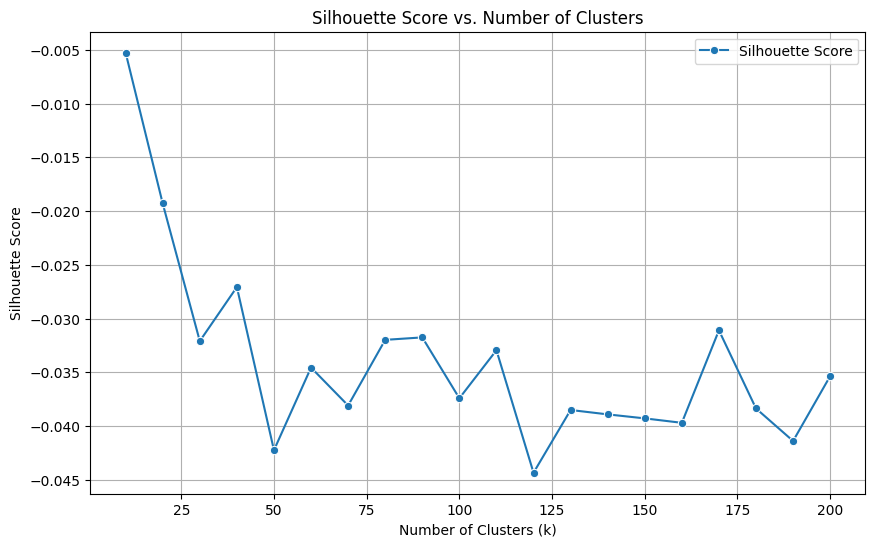

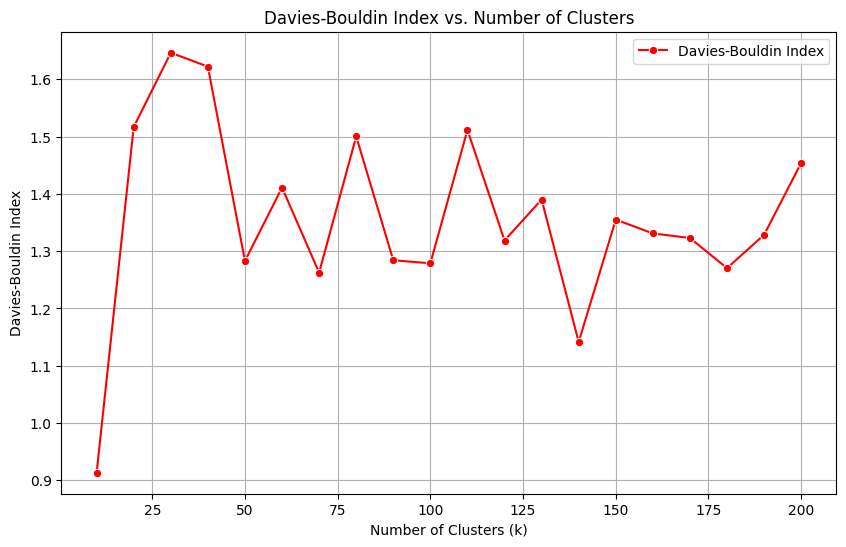

In [22]:
# Plot Silhouette Scores
plt.figure(figsize=(10,6))
sns.lineplot(x=list(cluster_range), y=silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Davies-Bouldin Scores
plt.figure(figsize=(10,6))
sns.lineplot(x=list(cluster_range), y=db_scores, marker='o', color='red', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# Define the optimal number of clusters based on evaluation
k_optimal = 10  # Replace with your chosen k

# Initialize Spectral Clustering
spectral = SpectralClustering(
    n_clusters=k_optimal,
    affinity='rbf',
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)

# Fit and predict cluster labels
print(f"Applying Spectral Clustering with k={k_optimal}...")
spectral_labels = spectral.fit_predict(tag_embeddings_normalized)
print("Spectral Clustering Completed.\n")


Applying Spectral Clustering with k=10...
Spectral Clustering Completed.



/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_59897/3187119032.py:20: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(


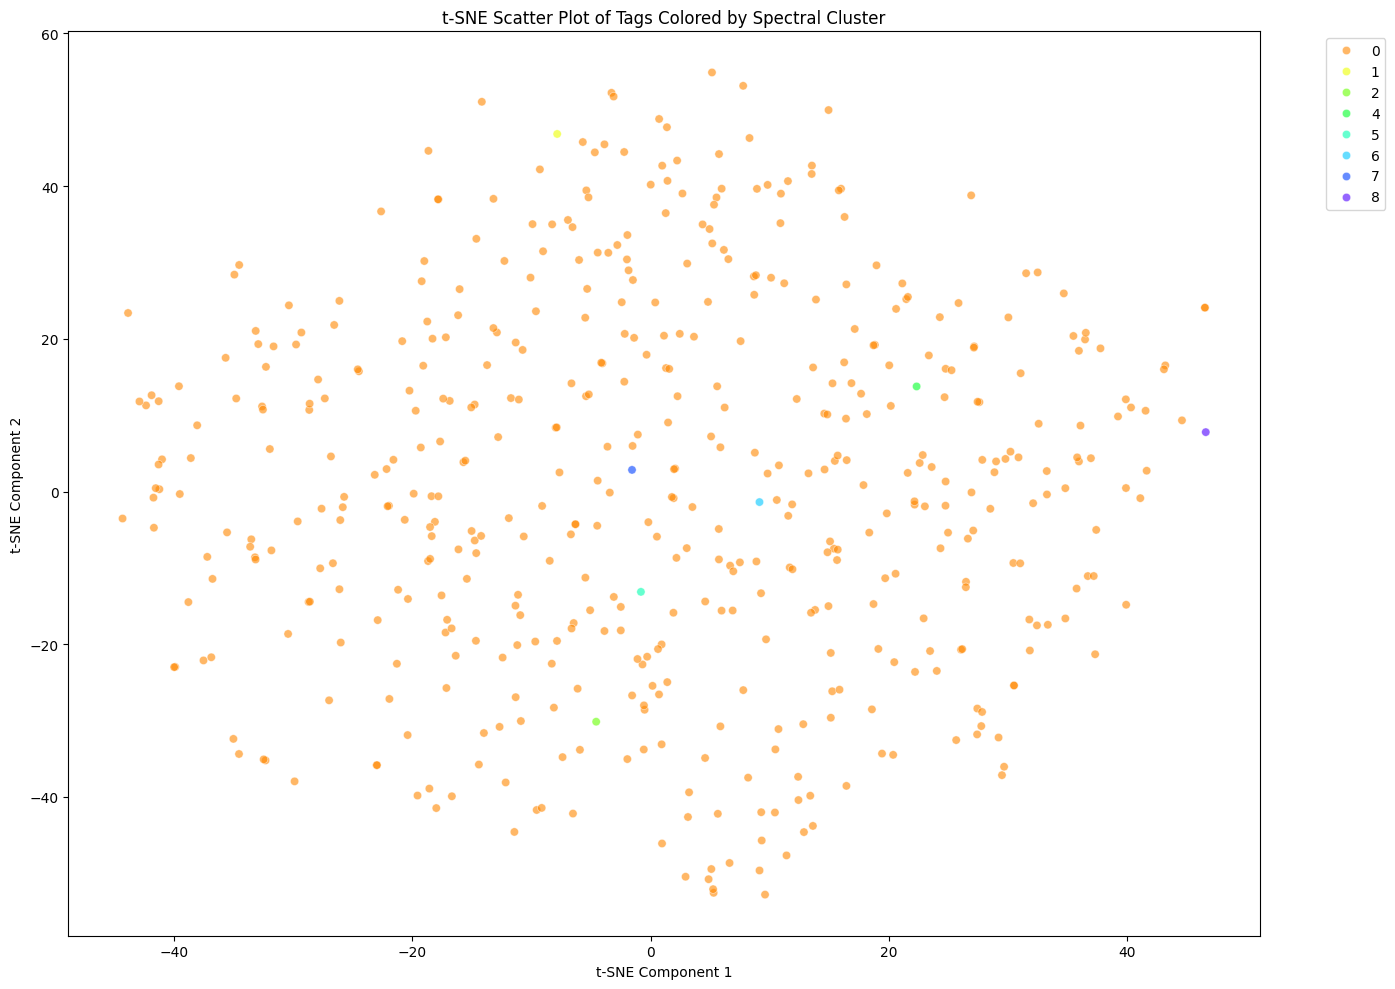

In [24]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

# Fit and transform the tag embeddings
tsne_components = tsne.fit_transform(tag_embeddings_normalized)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    'Tag': unique_tags,
    'Cluster': spectral_labels,
    'TSNE1': tsne_components[:,0],
    'TSNE2': tsne_components[:,1]
})

# Choose a color palette that can handle many clusters
palette = sns.color_palette("hsv", k_optimal)

# Plot the t-SNE scatter plot
plt.figure(figsize=(14,10))
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='Cluster', 
    palette=palette, 
    data=tsne_df.sample(n=500, random_state=42),  # Sampling for clarity
    legend='full',
    alpha=0.6
)
plt.title('t-SNE Scatter Plot of Tags Colored by Spectral Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_59897/3055488821.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=tsne_df, palette='viridis')


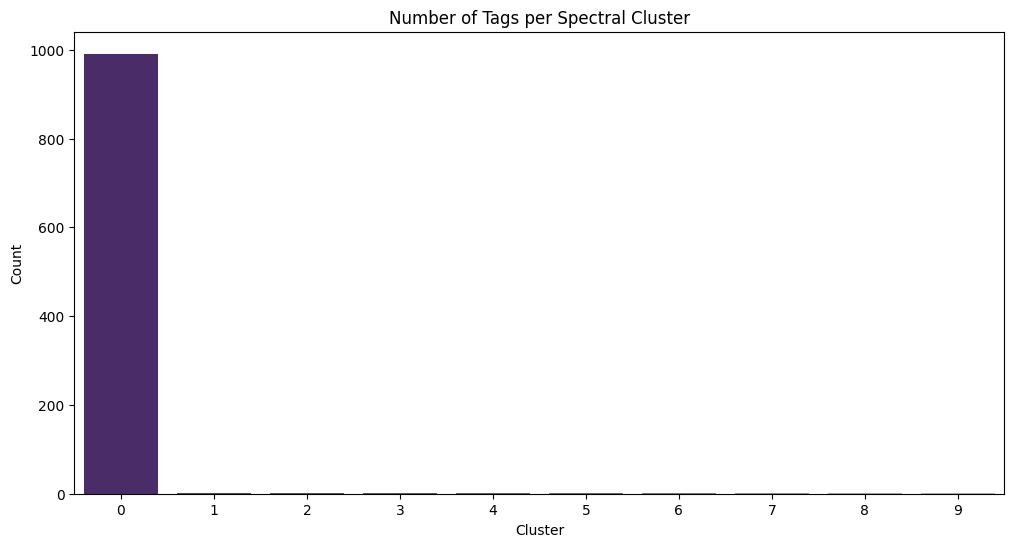

In [25]:
plt.figure(figsize=(12,6))
sns.countplot(x='Cluster', data=tsne_df, palette='viridis')
plt.title('Number of Tags per Spectral Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [26]:
# Create a DataFrame mapping tags to clusters
tags_clustered = pd.DataFrame({
    'Tag': unique_tags,
    'Cluster': spectral_labels
})

# Function to display top tags per cluster
def display_top_tags(tags_df, k):
    for cluster in range(k):
        cluster_tags = tags_df[tags_df['Cluster'] == cluster]['Tag']
        print(f"\nCluster {cluster} ({len(cluster_tags)} tags):")
        print(cluster_tags.tolist()[:10])  # Display first 10 tags

# Display top tags for each cluster
display_top_tags(tags_clustered, k_optimal)



Cluster 0 (991 tags):
['animation', 'slackers', 'parody', 'visually appealing', 'chick flick', '1930s', 'fantasy', 'excellent script', 'twist ending', 'grim']

Cluster 1 (1 tags):
['eccentricity']

Cluster 2 (1 tags):
['wuxia']

Cluster 3 (1 tags):
['criterion']

Cluster 4 (1 tags):
['free to download']

Cluster 5 (1 tags):
['product placement']

Cluster 6 (1 tags):
['glbt']

Cluster 7 (1 tags):
['blaxploitation']

Cluster 8 (1 tags):
['depp & burton']

Cluster 9 (1 tags):
['liv tyler']


Variance per dimension: [0.00226841 0.00213101 0.00166188 0.00178689 0.00230294]...


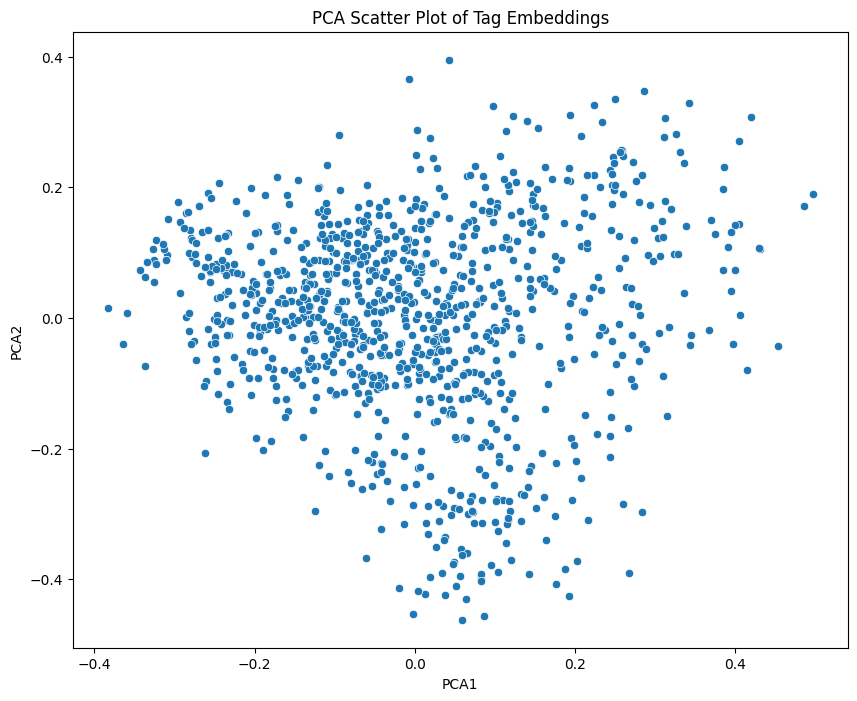

In [30]:
# Compute variance of each dimension
from sklearn.decomposition import PCA


variance = np.var(tag_embeddings, axis=0)
print(f"Variance per dimension: {variance[:5]}...")  # Display first 5 for brevity

# Plot PCA to inspect spread
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tag_embeddings)
pca_df = pd.DataFrame({
    'Tag': unique_tags,
    'PCA1': pca_result[:,0],
    'PCA2': pca_result[:,1]
})

plt.figure(figsize=(10,8))
sns.scatterplot(x='PCA1', y='PCA2', data=pca_df)
plt.title('PCA Scatter Plot of Tag Embeddings')
plt.show()

K means clustering on embeddings. 

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(tag_embeddings_normalized)


In [29]:
# -------------------------------
# 7. Analyzing the Clusters
# -------------------------------
tags_clustered = pd.DataFrame({
    'Tag': unique_tags,
    'Cluster': kmeans_labels
})

# Function to display top tags per cluster
def display_top_tags(tags_df, k):
    for cluster in range(k):
        cluster_tags = tags_df[tags_df['Cluster'] == cluster]['Tag']
        print(f"\nCluster {cluster} ({len(cluster_tags)} tags):")
        print(cluster_tags.tolist()[:10])  # Display first 10 tags

# Display top tags for each cluster
display_top_tags(tags_clustered, k_optimal)



Cluster 0 (63 tags):
['excellent script', 'ensemble cast', 'great soundtrack', 'enormously long battle scene', 'bad acting', 'beautifully filmed', 'directorial debut', 'great acting', 'great cinematography', 'bad sequel']

Cluster 1 (53 tags):
['nudity (full frontal)', 'touching', 'love', 'romance', 'marriage', 'homosexuality', 'father son relationship', 'pregnancy', 'wedding', 'father daughter relationship']

Cluster 2 (169 tags):
['slackers', '1930s', 'dance', 'time travel', 'androids', 'computers', 'aviation', 'black and white', 'history', 'space']

Cluster 3 (65 tags):
['vengeance', 'crime', 'gangsters', 'murder', 'surveillance', 'mystery', 'organized crime', 'guns', 'conspiracy', 'police corruption']

Cluster 4 (58 tags):
['dinosaurs', 'goth', 'noir', 'vampires', 'dark', 'dragons', 'spiders', 'jews', 'gore', 'religion']

Cluster 5 (106 tags):
['parody', 'grim', 'jesus', 'downbeat', 'long', 'funny', 'hilarious', 'twist', 'true story', 'satire']

Cluster 6 (150 tags):
['war', 'lone

/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


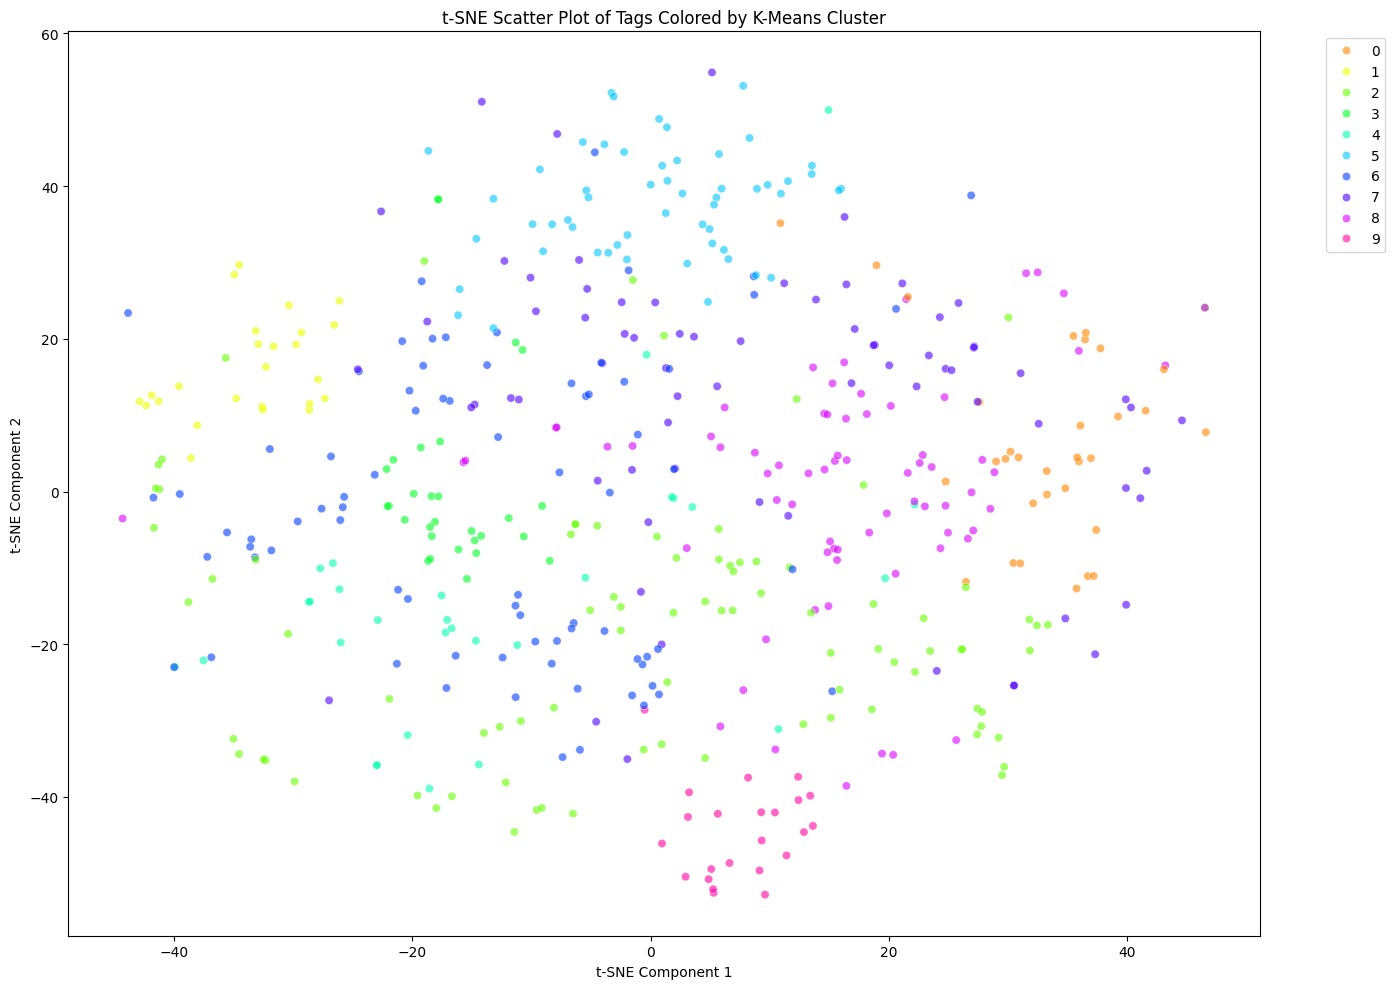

In [31]:
# -------------------------------
# 6. Visualizing the Clusters
# -------------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(tag_embeddings_normalized)
tsne_df = pd.DataFrame({
    'Tag': unique_tags,
    'Cluster': kmeans_labels,
    'TSNE1': tsne_results[:,0],
    'TSNE2': tsne_results[:,1]
})

# Choose a color palette that can handle many clusters
palette = sns.color_palette("hsv", k_optimal)

plt.figure(figsize=(14,10))
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='Cluster', 
    palette=palette, 
    data=tsne_df.sample(n=500, random_state=42),  # Sampling for clarity
    legend='full',
    alpha=0.6
)
plt.title('t-SNE Scatter Plot of Tags Colored by K-Means Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [39]:
# Initialize lists to store evaluation metrics
silhouette_scores = []
db_scores = []

for k in cluster_range:
    print(f"Clustering with k={k}")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(tag_embeddings_normalized)
    
    # Calculate Silhouette Score
    silhouette = silhouette_score(tag_embeddings_normalized, kmeans_labels)
    silhouette_scores.append(silhouette)
    
    # Calculate Davies-Bouldin Index
    db_score = davies_bouldin_score(tag_embeddings_normalized, kmeans_labels)
    db_scores.append(db_score)
    
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_score:.4f}\n")


Clustering with k=10
Silhouette Score: 0.0276
Davies-Bouldin Index: 4.6307

Clustering with k=20
Silhouette Score: 0.0341
Davies-Bouldin Index: 4.0512

Clustering with k=30
Silhouette Score: 0.0417
Davies-Bouldin Index: 3.5297

Clustering with k=40
Silhouette Score: 0.0460
Davies-Bouldin Index: 3.3249

Clustering with k=50
Silhouette Score: 0.0468
Davies-Bouldin Index: 3.1538

Clustering with k=60
Silhouette Score: 0.0509
Davies-Bouldin Index: 2.9790

Clustering with k=70
Silhouette Score: 0.0537
Davies-Bouldin Index: 2.8100

Clustering with k=80
Silhouette Score: 0.0575
Davies-Bouldin Index: 2.6811

Clustering with k=90
Silhouette Score: 0.0583
Davies-Bouldin Index: 2.5539

Clustering with k=100
Silhouette Score: 0.0663
Davies-Bouldin Index: 2.4854

Clustering with k=110
Silhouette Score: 0.0675
Davies-Bouldin Index: 2.4155

Clustering with k=120
Silhouette Score: 0.0675
Davies-Bouldin Index: 2.3570

Clustering with k=130
Silhouette Score: 0.0736
Davies-Bouldin Index: 2.2406

Clusteri

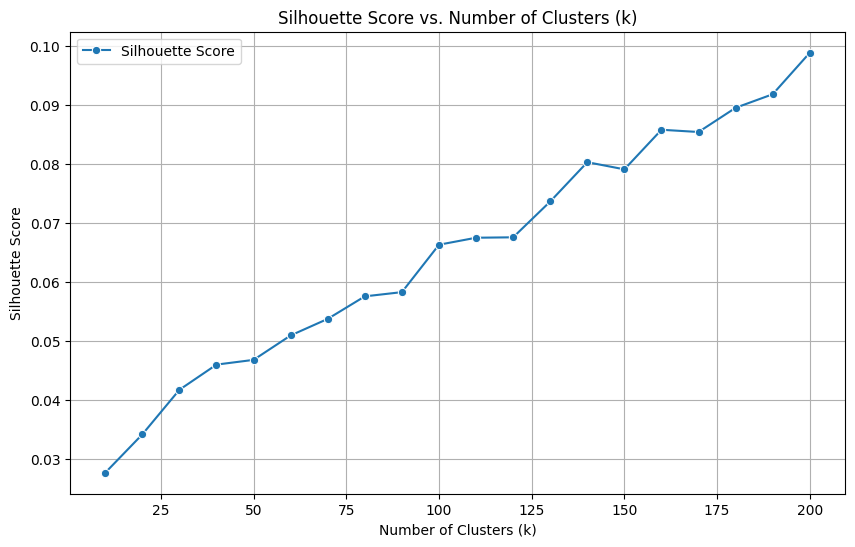

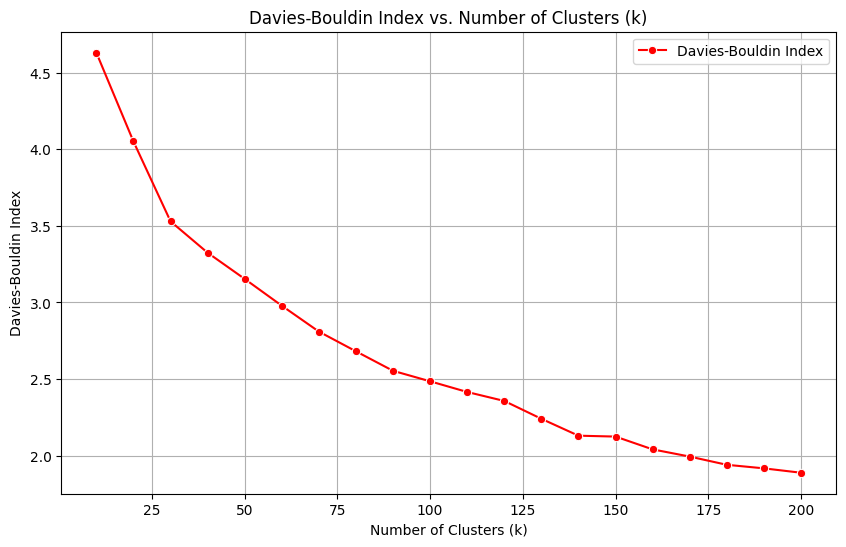

In [40]:
# Plot Silhouette Scores
plt.figure(figsize=(10,6))
sns.lineplot(x=list(cluster_range), y=silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Davies-Bouldin Scores
plt.figure(figsize=(10,6))
sns.lineplot(x=list(cluster_range), y=db_scores, marker='o', color='red', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# Define the optimal number of clusters based on evaluation
k_optimal = 10  # Replace with your chosen k

# Initialize K-Means
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)

# Fit and predict cluster labels
print(f"Applying K-Means Clustering with k={k_optimal}...")
kmeans_labels = kmeans.fit_predict(tag_embeddings_normalized)
print("K-Means Clustering Completed.\n")


Applying K-Means Clustering with k=10...
K-Means Clustering Completed.



/Users/gustavsiphone/Documents/GitHub/02807_MovieLens_Recommendation/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


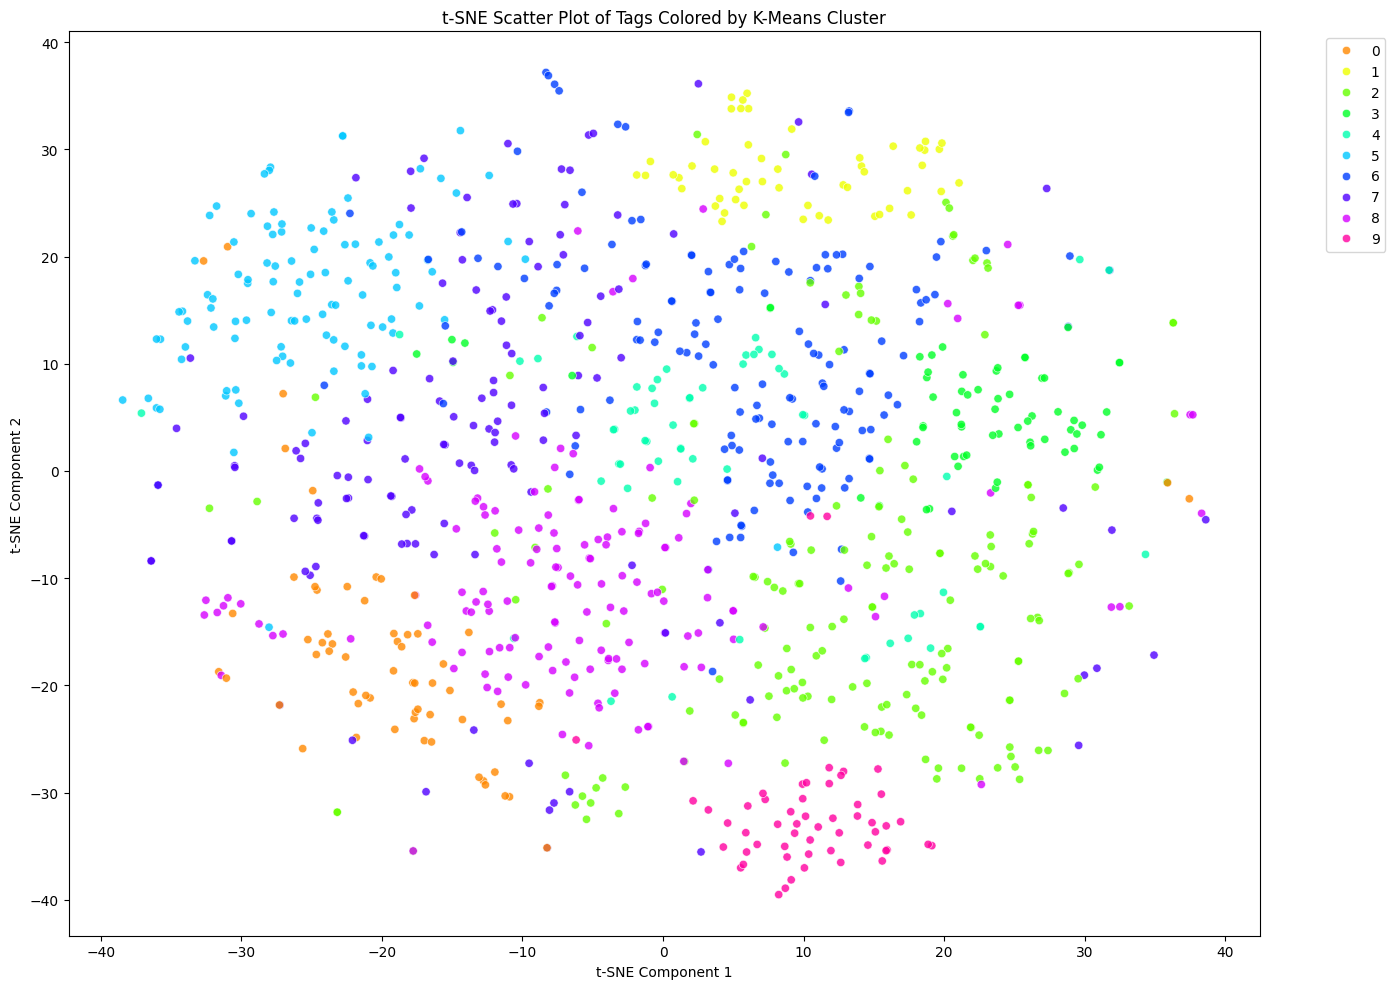

In [56]:
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=60, n_iter=2000)

# Fit and transform the tag embeddings
tsne_results = tsne.fit_transform(tag_embeddings_normalized)

# Create a DataFrame for visualization
tsne_df = pd.DataFrame({
    'Tag': unique_tags,
    'Cluster': kmeans_labels,
    'TSNE1': tsne_results[:,0],
    'TSNE2': tsne_results[:,1]
})

# Choose a color palette that can handle many clusters
palette = sns.color_palette("hsv", k_optimal)

# Plot the t-SNE scatter plot
plt.figure(figsize=(14,10))
sns.scatterplot(
    x='TSNE1', 
    y='TSNE2', 
    hue='Cluster', 
    palette=palette, 
    data=tsne_df,  # All tags
    legend='full',
    alpha=0.8
)
plt.title('t-SNE Scatter Plot of Tags Colored by K-Means Cluster')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_59897/1685460649.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=tsne_df, palette='viridis')


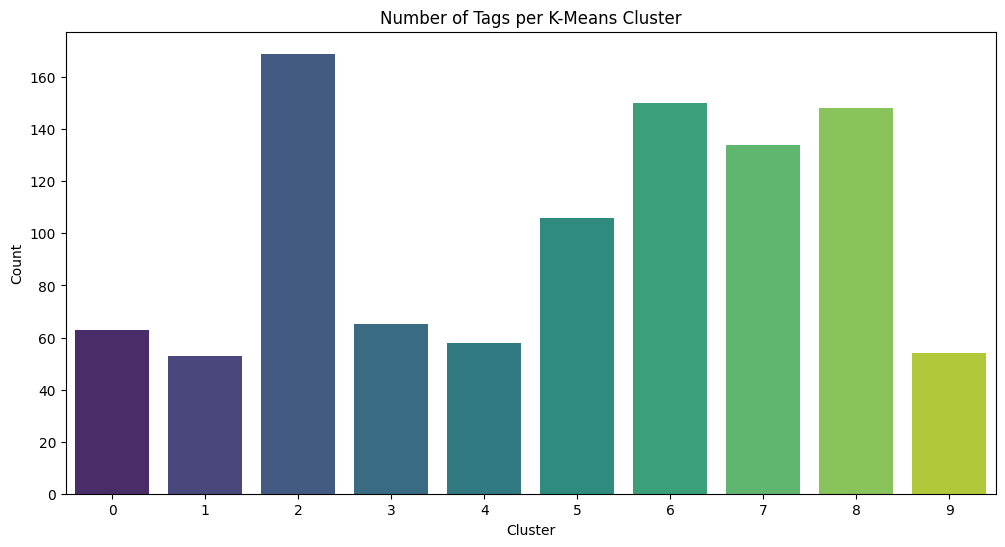

In [52]:
plt.figure(figsize=(12,6))
sns.countplot(x='Cluster', data=tsne_df, palette='viridis')
plt.title('Number of Tags per K-Means Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [53]:

display_top_tags(tags_clustered, k_optimal)



Cluster 0 (63 tags):
['excellent script', 'ensemble cast', 'great soundtrack', 'enormously long battle scene', 'bad acting', 'beautifully filmed', 'directorial debut', 'great acting', 'great cinematography', 'bad sequel']

Cluster 1 (53 tags):
['nudity (full frontal)', 'touching', 'love', 'romance', 'marriage', 'homosexuality', 'father son relationship', 'pregnancy', 'wedding', 'father daughter relationship']

Cluster 2 (169 tags):
['slackers', '1930s', 'dance', 'time travel', 'androids', 'computers', 'aviation', 'black and white', 'history', 'space']

Cluster 3 (65 tags):
['vengeance', 'crime', 'gangsters', 'murder', 'surveillance', 'mystery', 'organized crime', 'guns', 'conspiracy', 'police corruption']

Cluster 4 (58 tags):
['dinosaurs', 'goth', 'noir', 'vampires', 'dark', 'dragons', 'spiders', 'jews', 'gore', 'religion']

Cluster 5 (106 tags):
['parody', 'grim', 'jesus', 'downbeat', 'long', 'funny', 'hilarious', 'twist', 'true story', 'satire']

Cluster 6 (150 tags):
['war', 'lone

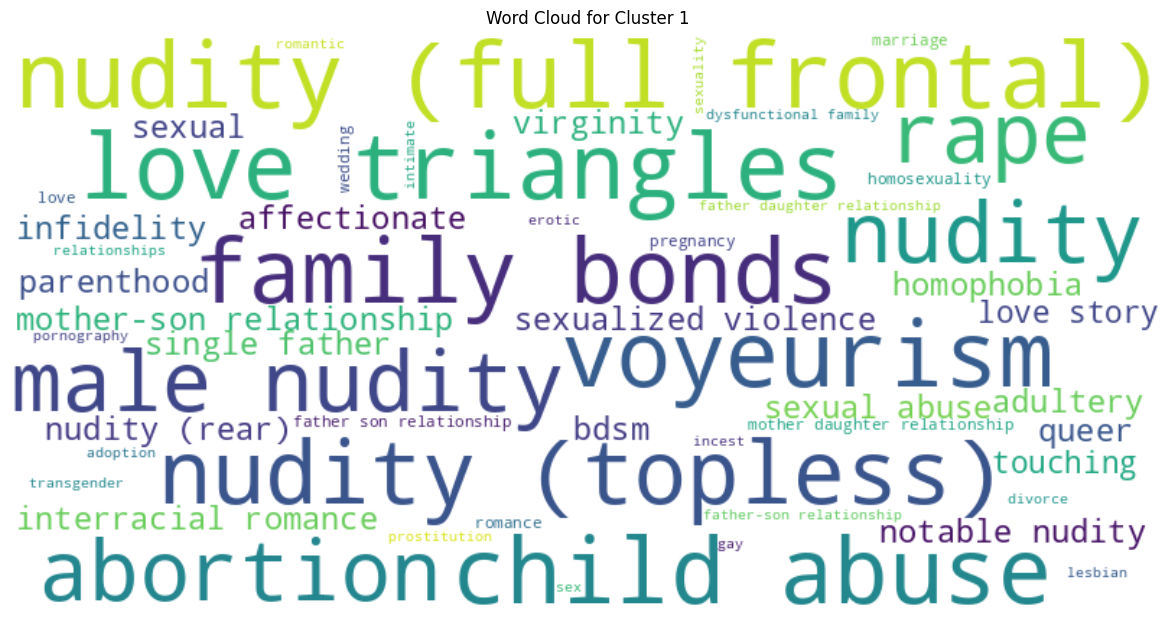

In [54]:
# -------------------------------
# 8. Word Cloud for a Specific Cluster
# -------------------------------
def generate_wordcloud(cluster_id, tags_df):
    cluster_tags = tags_df[tags_df['Cluster'] == cluster_id]['Tag']
    tag_freq = pd.Series(cluster_tags).value_counts().to_dict()
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_freq)
    
    plt.figure(figsize=(15,7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.show()

# Generate word cloud for a selected cluster
selected_cluster = 1  # Change as needed
generate_wordcloud(selected_cluster, tags_clustered)


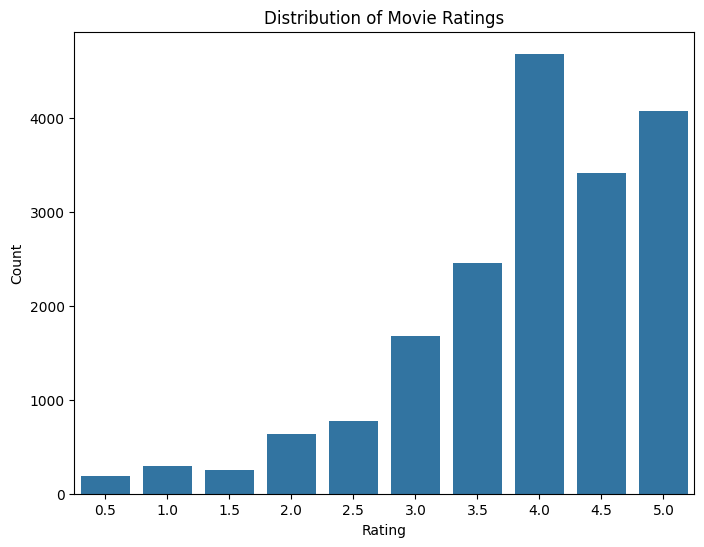

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=dt)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_14596/3356505072.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rating_count', y='title', data=top_movies, palette='viridis')


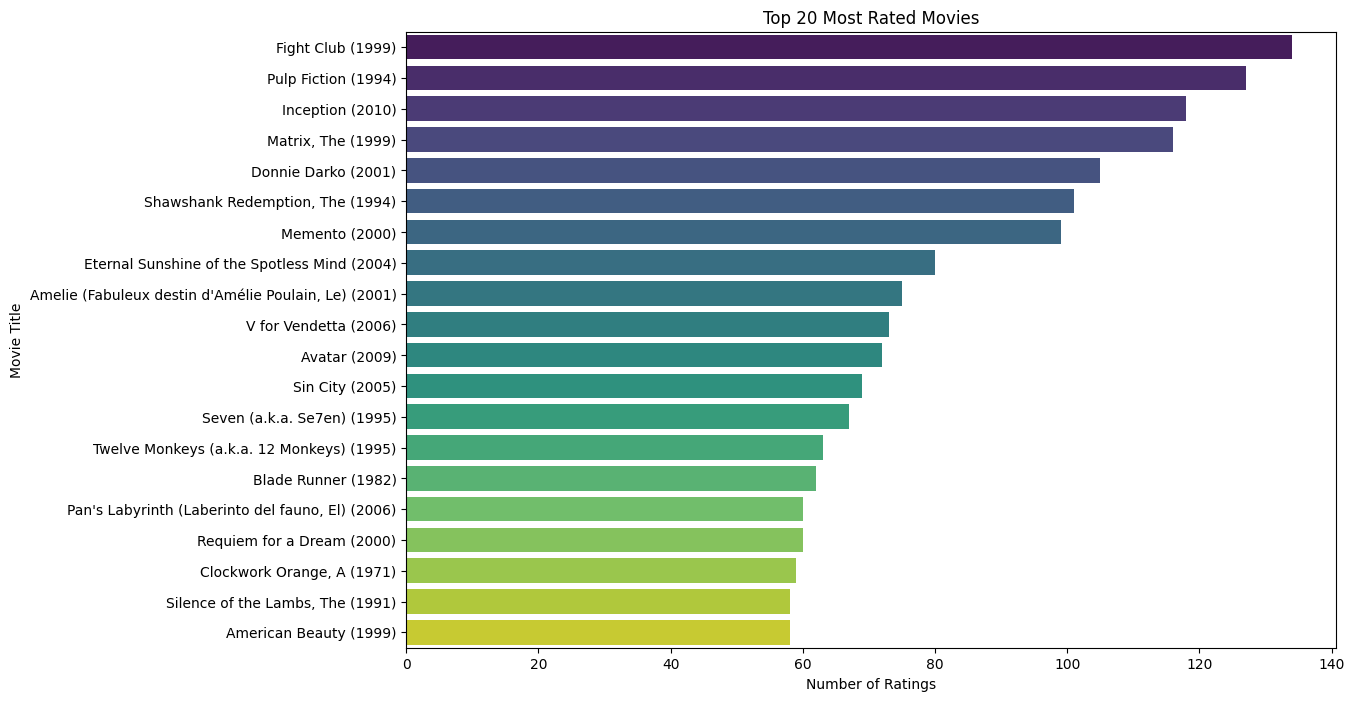

In [7]:
# Top 20 most rated movies
top_movies = dt['movieId'].value_counts().head(20).reset_index()
top_movies.columns = ['movieId', 'rating_count']
top_movies = top_movies.merge(dt[['movieId', 'title']], on='movieId')

plt.figure(figsize=(12,8))
sns.barplot(x='rating_count', y='title', data=top_movies, palette='viridis')
plt.title('Top 20 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


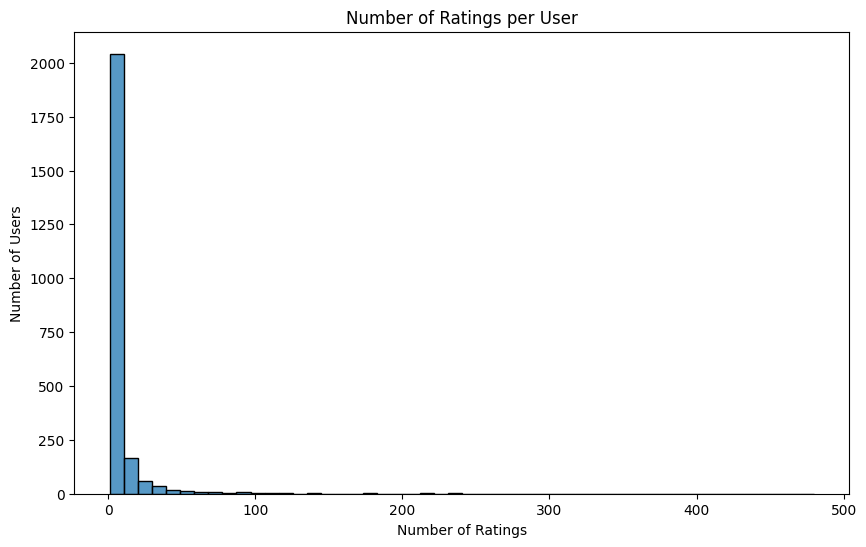

In [8]:
user_rating_counts = dt['userId'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(user_rating_counts, bins=50, kde=False)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_14596/2069072204.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')


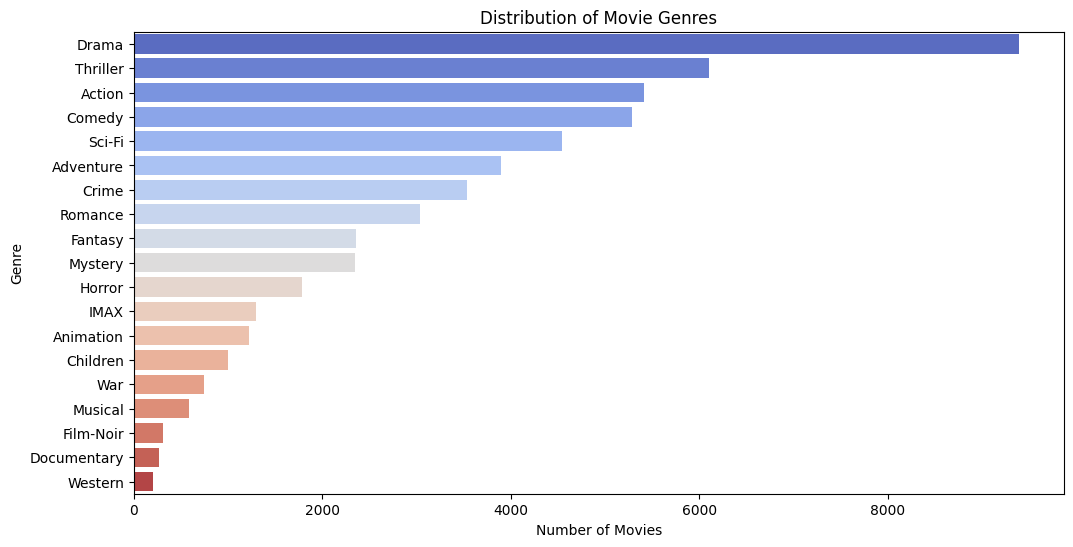

In [10]:
# Split genres and count
genres = dt['genres'].str.get_dummies(sep='|')
genre_counts = genres.sum().sort_values(ascending=False).reset_index()
genre_counts.columns = ['genre', 'count']

plt.figure(figsize=(12,6))
sns.barplot(x='count', y='genre', data=genre_counts, palette='coolwarm')
plt.title('Distribution of Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


/var/folders/by/z4t2j23n5qb8_7scg2s_mjg00000gn/T/ipykernel_14596/1025126462.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='tag', data=top_tags, palette='magma')


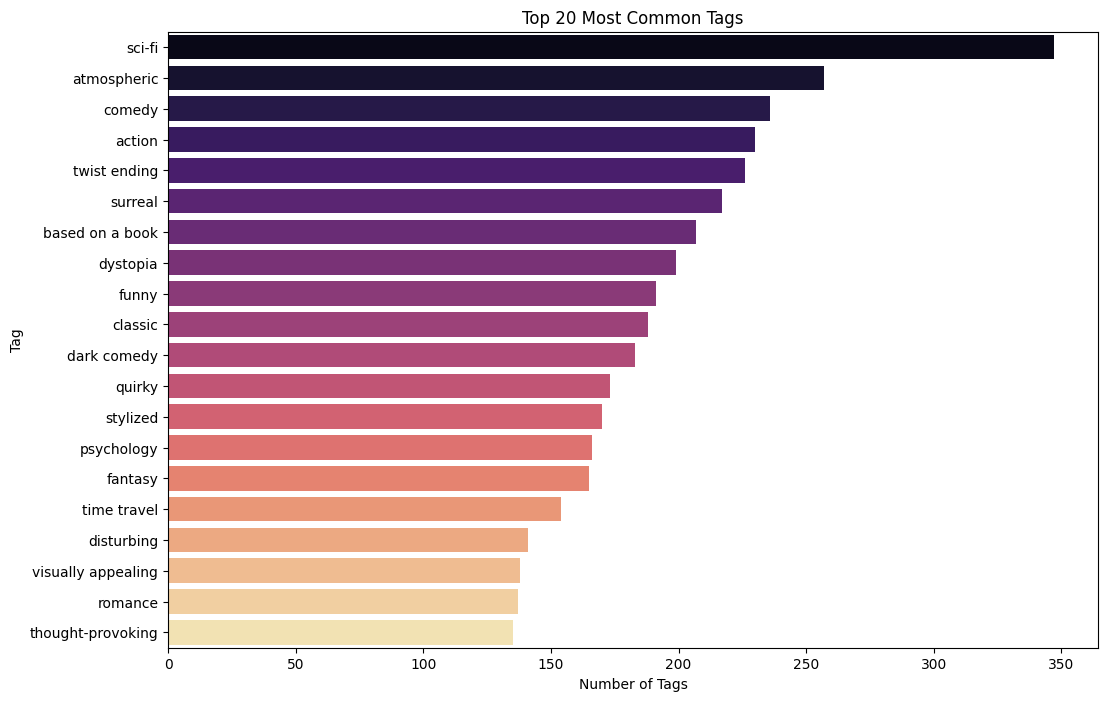

In [12]:
top_tags = dt['tag'].value_counts().head(20).reset_index()
top_tags.columns = ['tag', 'count']

plt.figure(figsize=(12,8))
sns.barplot(x='count', y='tag', data=top_tags, palette='magma')
plt.title('Top 20 Most Common Tags')
plt.xlabel('Number of Tags')
plt.ylabel('Tag')
plt.show()


In [14]:
print(dt['timestamp'].head())
print(dt['timestamp'].dtype)


0    2014-05-01 21:59:03
1    2015-02-01 00:12:05
2    2009-02-10 01:52:13
3    2012-12-15 17:57:01
4    2013-09-03 16:07:46
Name: timestamp, dtype: object
object


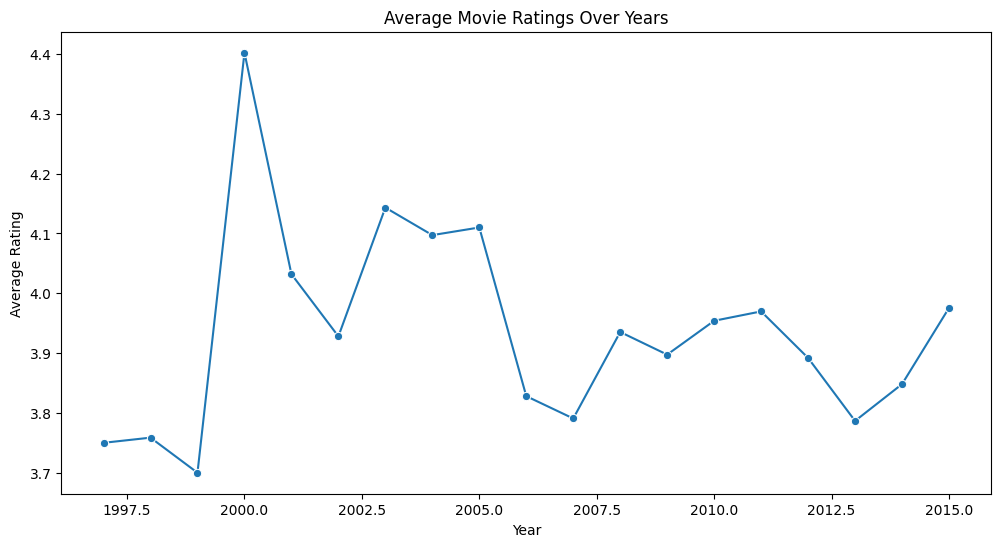

In [15]:



# Convert 'timestamp' to datetime
dt['timestamp'] = pd.to_datetime(dt['timestamp'])

# Extract the year from the timestamp
dt['year'] = dt['timestamp'].dt.year

# Calculate average rating per year
avg_ratings_year = dt.groupby('year')['rating'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='rating', data=avg_ratings_year, marker='o')
plt.title('Average Movie Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


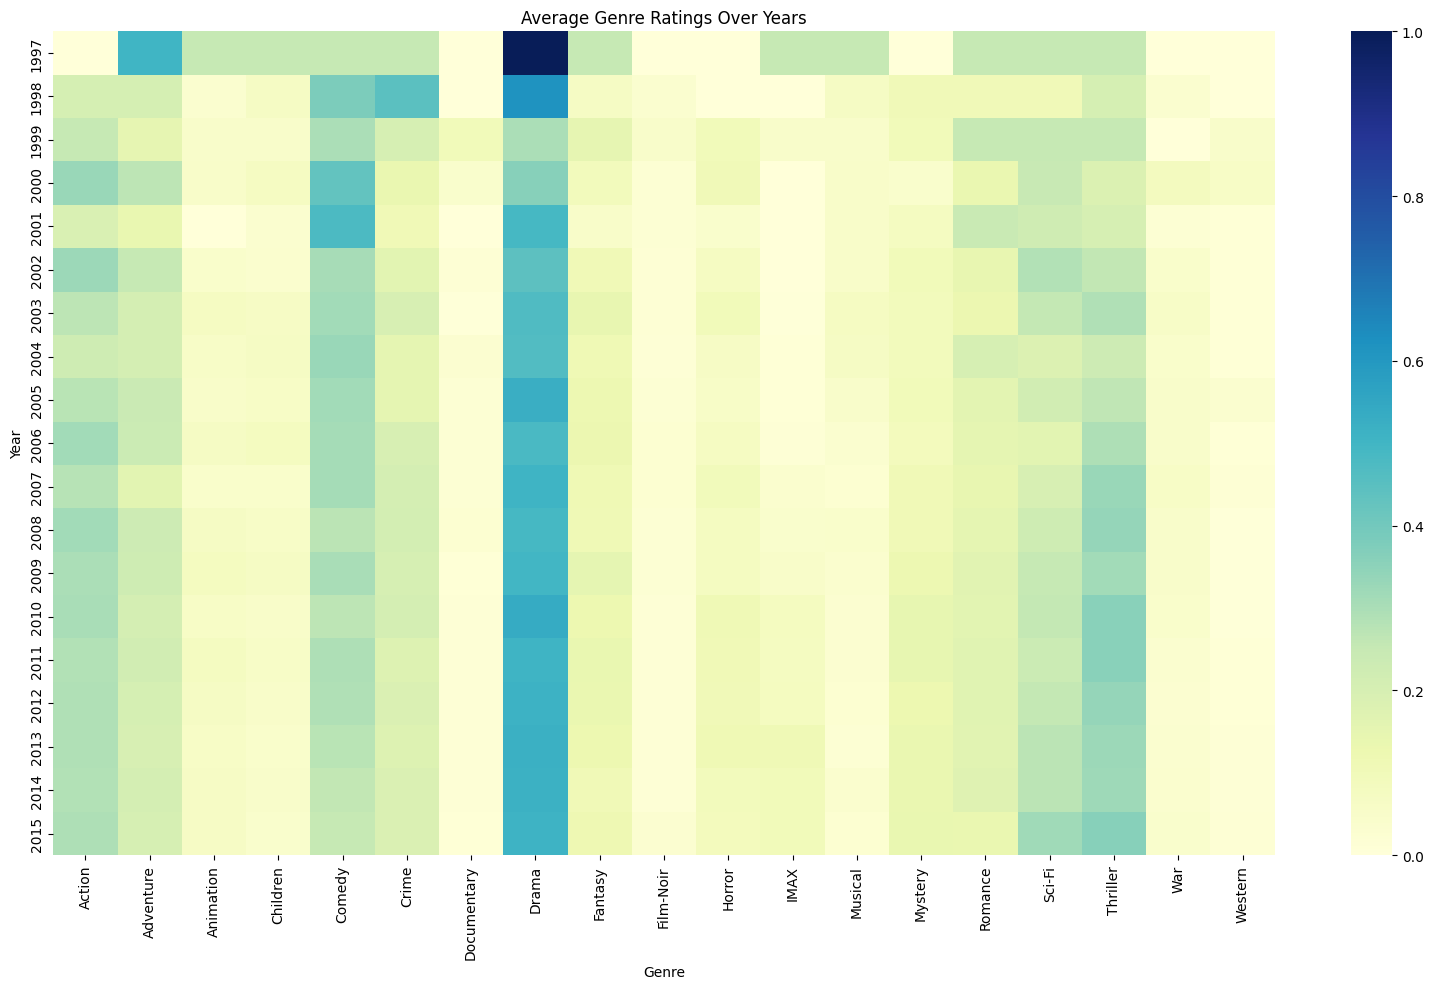

In [16]:
# Split genres and create dummy variables
genres_split = dt['genres'].str.get_dummies(sep='|')

# Merge with the main DataFrame
dt_with_genres = pd.concat([dt, genres_split], axis=1)

# Calculate average rating per year per genre
genre_year_rating = dt_with_genres.groupby('year')[genres_split.columns].mean()

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(genre_year_rating, cmap='YlGnBu', annot=False)
plt.title('Average Genre Ratings Over Years')
plt.xlabel('Genre')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA

# Assuming movie_features_normalized is your feature matrix
pca = PCA(n_components=2)
pca_components = pca.fit_transform(movie_features_normalized)

pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['movieId'] = movie_features_normalized.index

# Merge with cluster labels
pca_df = pca_df.merge(movie_clusters_kmeans, on='movieId')

plt.figure(figsize=(12,8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', palette='tab20', data=pca_df, legend='full', alpha=0.6)
plt.title('PCA Scatter Plot of Movies Colored by Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [ ]:
plt.figure(figsize=(8,6))
sns.histplot(genome_scores['relevance'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Genome Tag Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Frequency')
plt.show()


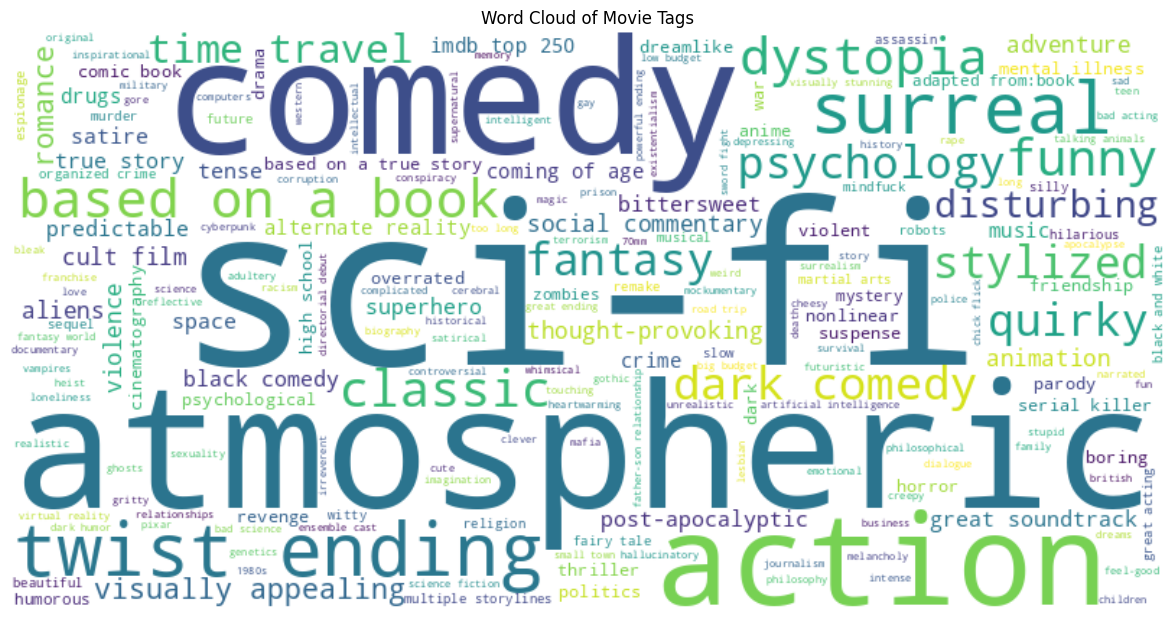

In [13]:
from wordcloud import WordCloud

# Generate word frequencies
tag_freq = dt['tag'].value_counts().to_dict()

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_freq)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.show()
